# BERT probe training
### Author - gromdimon
### 30.06.2023

## Some technical information

### What is BERT?
BERT is a Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications.

### Core idea under the hood
If the language models trying to fill gaps in text, BERT is trying to predict the next word in the sentence. The difference is that BERT is trained on a huge amount of data, and the model is very deep. The model is trained on two tasks: Masked Language Model and Next Sentence Prediction. The first task is to predict the masked word in the sentence. The second task is to predict whether the second sentence is the next sentence in the original text. The model is trained on a huge amount of data, and the model is very deep. The model is trained on two tasks: Masked Language Model and Next Sentence Prediction. The first task is to predict the masked word in the sentence. The second task is to predict whether the second sentence is the next sentence in the original text.

### BERT architecture
BERT is a multi-layer bidirectional Transformer encoder. There are two models:
- The base model is a 12-layer, 768-hidden, 12-heads, 110M parameter neural network architecture.
- The large model is a 24-layer, 1024-hidden, 16-heads, 340M parameter neural network architecture.

Both models are pre-trained on a large corpus of unlabelled text, and can be fine-tuned on labelled data for a wide range of tasks like classification, language inference, question answering and others.

## Workflow

### 1. Data preparation
BERT relies on a Transformer arvhitecture. A basic Transformer cosist of an encoder to read the text input and a decoder to produce a prediction for the task. Since BERT's goal is to generate a language representation model, it only needs the encoder part. The input to the encoder for BERT is a sequende of tokens, which are first converted into vectors and then processed in the neural network. For start, every input embedding is a combination of 3 embeddings:
- **Position Embeddings** - A positional embedding is a sine and cosine function with different frequencies. The frequency of the wave is determined by the position of the word in the sequence. The position embedding is added to the token embedding to inform the model of the position of each word in the sequence.
- **Segment Embeddings** - BERT can also take sentence pairs as inputs for tasks (Question-Answering). That's why it needs a way to distinguish between the two sentences in the input. To do so, it adds a learnable embedding to every token of the first sentence and adds a different learnable embedding to every token of the second sentence. These are called segment embeddings.
- **Token Embeddings** - These are the embeddings of the individual tokens in the input sequence. These are the embeddings which will be learned during the training process.

### 2. Pre-training
BERT is pre-trained using two unsupervised tasks:
- **Masked Language Model** - Before feeding word sequences into BERT, 15% of the words in each sequence are replaced with a [MASK] token. The model then attempts to predict the original value of the masked words, based on the context provided by the other, non-masked, words in the sequence. In technical terms, the prediction of the output words requires:
    - Adding a classification layer on top of the encoder output.
    - Multiplying the output vectors by the embedding matrix, transforming them into the vocabulary dimension.
    - Calculating the probability of each word in the vocabulary with softmax.
- **Next Sentence Prediction** - In the next sentence prediction task, the model receives pairs of sentences as input and learns to predict if the second sentence in the pair is the subsequent sentence in the original document. During training, 50% of the inputs are a pair in which the second sentence is the subsequent sentence in the original document, while in the other 50% a random sentence from the corpus is chosen as the second sentence. The assumption is that the random sentence will be disconnected from the first sentence. This task is trivially implemented by adding a classification layer on top of the encoder output and training it on the two sentences input pairs with binary cross entropy.

### 3. Fine-tuning
After pre-training, BERT is ready to be fine-tuned on specific tasks. The model is first initialized with the pre-trained parameters, and all of the parameters are fine-tuned using task-specific labeled data. In fine-tuning, all parameters are fine-tuned, meaning that all of the parameters are updated based on the task-specific objective function, rather than keeping some of the parameters fixed as in feature-based approaches.

## Implementation

In [1]:
## Importing Libraries
import time
t0start = time.time()
%pip install transformers
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import transformers
from transformers import AutoModel, BertTokenizerFast
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Specify device
# device = torch.device('cuda')
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cpu


In [3]:
# Import Dataset from
# https://www.kaggle.com/datasets/kumargaurav7/spamdatatest
# The import path may vary!
path = 'spamdata_v2.csv'
df = pd.read_csv(path)
print('Shape of dataset: ', df.shape)
df.head()

Shape of dataset:  (5572, 2)


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# The dataset contains 2 columns: text and label
df.label.value_counts()

0    4825
1     747
Name: label, dtype: int64

In [5]:
# Splitting the dataset into train and test set
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [6]:
# Importing the BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<AxesSubplot: >

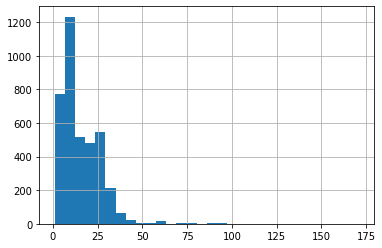

In [7]:
# Get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

### Tokenization
BERT uses WordPiece tokenization. The vocabulary is initialized with all the individual characters in the language, and then the most frequent/likely combinations of the existing words in the vocabulary are iteratively added. The vocabulary is fixed before training and is not updated during training.

**Maximal length** - The maximum length of a sequence is 512 tokens. If the sequence is longer than 512 tokens, the sequence is truncated from the beginning or end of the sequence. If the sequence is shorter than 512 tokens, it is padded with 0s.

In [8]:
# Tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/Users/gromdimon/Working/workspace/.venv8/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [9]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [10]:
# Data Loader Class
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Define a batch size
batch_size = 32

# Wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# Sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# Sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# DataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [11]:
# Freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [12]:
# Define model architecture
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [13]:
# Pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# Push to GPU
model = model.to(device)

In [14]:
# Optimizer
from transformers import AdamW

# Define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)

/Users/gromdimon/Working/workspace/.venv8/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
from sklearn.utils.class_weight import compute_class_weight

# Compute the class weights
class_wts = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
)

print(class_wts)

[0.57743559 3.72848948]


In [16]:
# Converting list of class weights to a tensor
weights= torch.tensor(class_wts, dtype=torch.float)

# Push to GPU
weights = weights.to(device)

# Loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# Number of training epochs
epochs = 10

In [17]:
# Function to train the model
def train():

    model.train()

    total_loss, total_accuracy = 0, 0

    # Empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [18]:
# Function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        # push the batch to gpu
        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [19]:
%%time
# Set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# For each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.686
Validation Loss: 0.667

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.651
Validation Loss: 0.635

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.622
Validation Loss: 0.610

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.602
Validation Loss: 0.578

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.581
Validation Loss: 0.560

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.560
Validation Loss: 0.536

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.540
Validation Loss: 0.512

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.521
Validat

In [20]:
# Load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [21]:
# Make predictions
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

# model performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91       724
           1       0.47      0.83      0.60       112

    accuracy                           0.85       836
   macro avg       0.72      0.84      0.75       836
weighted avg       0.90      0.85      0.87       836



In [22]:
tt = time.time() - t0start
print('%.1f seconds ( = %.1f minutes, = %.2f hours) passed'%( tt, tt/60, tt/3600 ) )

579.7 seconds ( = 9.7 minutes, = 0.16 hours) passed


## References & Credits
1. [BERT for "Everyone"](https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation/notebook)